In [64]:
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

### LightGBM

In [65]:
df_train = pd.read_csv('../data/train_con_features_encoded.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('../data/test_con_features_encoded.csv', index_col='Unnamed: 0')
display(df_train.head())

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,...,estado_titulo,cantidad_palabras_descripcion,relacion_palabras_descripcion,es_ciudad_capital,ciudad_turistica_top15,anio,mes,tipodepropiedad_cb,ciudad_cb,provincia_cb
0,254099,8.116114,2.0,1.0,2.0,80.0,80.0,23533.0,NaN,NaN,...,0,0,0.000000,0,0,2015,8,2.763765e+06,3.384582e+06,3.471689e+06
1,53461,10.000000,3.0,2.0,2.0,268.0,180.0,24514.0,19.310205,-99.227655,...,0,1,0.007968,0,0,2013,6,2.898908e+06,4.604780e+06,3.471689e+06
2,247984,5.000000,3.0,2.0,2.0,144.0,166.0,48551.0,NaN,NaN,...,0,10,0.046957,0,0,2015,10,2.398159e+06,8.890818e+05,2.367701e+06
3,209067,1.000000,2.0,1.0,1.0,63.0,67.0,53666.0,19.301890,-99.688015,...,0,0,0.000000,0,0,2012,3,2.398159e+06,1.479134e+06,2.762459e+06
4,185997,10.000000,2.0,1.0,1.0,95.0,95.0,47835.0,NaN,NaN,...,0,1,0.074108,0,0,2016,6,2.763765e+06,2.749654e+06,2.367701e+06


In [66]:
#Guardo y remuevo la columna id de los datos
id_col = df_test['id']
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

#Separo features de entrenamiento del precio
feature_cols = df_train.columns.tolist()
feature_cols.remove('precio')

X = df_train[feature_cols]
y = df_train['precio']

feature_cols

['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'hermoso_titulo',
 'estado_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(180000, 39) (180000,)
(60000, 39) (60000,)


In [68]:
import lightgbm as lgb
from sklearn import metrics

#Se hizo una pasada para detectar ajustar hiperparametros y se mejoró manualmente
'''clf = lgb.LGBMRegressor()

gridParams = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'min_data_in_leaf':[10],
    'metric':['mae']
    }

grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
grid.fit(X_train,y_train)

grid.best_params_'''

"clf = lgb.LGBMRegressor()\n\ngridParams = {\n    'learning_rate': [0.05],\n    'num_leaves': [90,200],\n    'boosting_type' : ['gbdt'],\n    'objective' : ['regression'],\n    'max_depth' : [5,6,7,8],\n    'random_state' : [501], \n    'colsample_bytree' : [0.5,0.7],\n    'min_data_in_leaf':[10],\n    'metric':['mae']\n    }\n\ngrid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)\ngrid.fit(X_train,y_train)\n\ngrid.best_params_"

In [69]:
best_params = {
    'learning_rate': 0.04,      #best=0.04   
    'num_leaves': 512,          #best=512    MAE=521747 CATBOOST ENCODED ---> k=40
    'max_depth' : 12,           #best=12     MAE=XXXXXX  CATBOOST(ciudades) + ONE HOT ENCODED ---> k=70
    'objective' : 'regression', #            
    'random_state' : 501,       #best=501   
    'colsample_bytree' : 0.5,   #best=0.5   
    'min_data_in_leaf':10,      #best=10
    'metric':['mae']
    }

In [70]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

LightGBM = lgb.train(best_params, lgb_train, num_boost_round=1500, valid_sets=lgb_eval, early_stopping_rounds=10)

[1]	valid_0's l1: 1.57677e+06
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l1: 1.52943e+06
[3]	valid_0's l1: 1.48536e+06
[4]	valid_0's l1: 1.44302e+06
[5]	valid_0's l1: 1.41135e+06
[6]	valid_0's l1: 1.37465e+06
[7]	valid_0's l1: 1.33689e+06
[8]	valid_0's l1: 1.30368e+06
[9]	valid_0's l1: 1.27051e+06
[10]	valid_0's l1: 1.23956e+06
[11]	valid_0's l1: 1.20824e+06
[12]	valid_0's l1: 1.17926e+06
[13]	valid_0's l1: 1.15278e+06
[14]	valid_0's l1: 1.12474e+06
[15]	valid_0's l1: 1.09944e+06
[16]	valid_0's l1: 1.07481e+06
[17]	valid_0's l1: 1.05195e+06
[18]	valid_0's l1: 1.02951e+06
[19]	valid_0's l1: 1.01233e+06
[20]	valid_0's l1: 991538
[21]	valid_0's l1: 971289
[22]	valid_0's l1: 953100
[23]	valid_0's l1: 936861
[24]	valid_0's l1: 919640
[25]	valid_0's l1: 904186
[26]	valid_0's l1: 889269
[27]	valid_0's l1: 875672
[28]	valid_0's l1: 864211
[29]	valid_0's l1: 851168
[30]	valid_0's l1: 838535
[31]	valid_0's l1: 826786
[32]	valid_0's l1: 815435
[33]	valid_0's l1: 80

[304]	valid_0's l1: 543489
[305]	valid_0's l1: 543444
[306]	valid_0's l1: 543335
[307]	valid_0's l1: 543283
[308]	valid_0's l1: 543207
[309]	valid_0's l1: 543072
[310]	valid_0's l1: 542983
[311]	valid_0's l1: 542916
[312]	valid_0's l1: 542874
[313]	valid_0's l1: 542861
[314]	valid_0's l1: 542787
[315]	valid_0's l1: 542730
[316]	valid_0's l1: 542634
[317]	valid_0's l1: 542611
[318]	valid_0's l1: 542575
[319]	valid_0's l1: 542534
[320]	valid_0's l1: 542370
[321]	valid_0's l1: 542284
[322]	valid_0's l1: 542257
[323]	valid_0's l1: 542149
[324]	valid_0's l1: 542045
[325]	valid_0's l1: 542021
[326]	valid_0's l1: 541914
[327]	valid_0's l1: 541878
[328]	valid_0's l1: 541752
[329]	valid_0's l1: 541664
[330]	valid_0's l1: 541596
[331]	valid_0's l1: 541464
[332]	valid_0's l1: 541377
[333]	valid_0's l1: 541307
[334]	valid_0's l1: 541296
[335]	valid_0's l1: 541218
[336]	valid_0's l1: 541144
[337]	valid_0's l1: 541073
[338]	valid_0's l1: 541013
[339]	valid_0's l1: 540896
[340]	valid_0's l1: 540857
[

[608]	valid_0's l1: 531458
[609]	valid_0's l1: 531451
[610]	valid_0's l1: 531436
[611]	valid_0's l1: 531430
[612]	valid_0's l1: 531415
[613]	valid_0's l1: 531414
[614]	valid_0's l1: 531382
[615]	valid_0's l1: 531365
[616]	valid_0's l1: 531349
[617]	valid_0's l1: 531344
[618]	valid_0's l1: 531345
[619]	valid_0's l1: 531316
[620]	valid_0's l1: 531244
[621]	valid_0's l1: 531235
[622]	valid_0's l1: 531230
[623]	valid_0's l1: 531207
[624]	valid_0's l1: 531176
[625]	valid_0's l1: 531162
[626]	valid_0's l1: 531154
[627]	valid_0's l1: 531132
[628]	valid_0's l1: 531104
[629]	valid_0's l1: 531083
[630]	valid_0's l1: 531073
[631]	valid_0's l1: 531069
[632]	valid_0's l1: 531004
[633]	valid_0's l1: 530976
[634]	valid_0's l1: 530972
[635]	valid_0's l1: 530963
[636]	valid_0's l1: 530941
[637]	valid_0's l1: 530930
[638]	valid_0's l1: 530919
[639]	valid_0's l1: 530912
[640]	valid_0's l1: 530933
[641]	valid_0's l1: 530938
[642]	valid_0's l1: 530925
[643]	valid_0's l1: 530901
[644]	valid_0's l1: 530873
[

[917]	valid_0's l1: 526265
[918]	valid_0's l1: 526264
[919]	valid_0's l1: 526225
[920]	valid_0's l1: 526221
[921]	valid_0's l1: 526224
[922]	valid_0's l1: 526194
[923]	valid_0's l1: 526190
[924]	valid_0's l1: 526169
[925]	valid_0's l1: 526146
[926]	valid_0's l1: 526146
[927]	valid_0's l1: 526124
[928]	valid_0's l1: 526128
[929]	valid_0's l1: 526103
[930]	valid_0's l1: 526088
[931]	valid_0's l1: 526072
[932]	valid_0's l1: 526048
[933]	valid_0's l1: 526045
[934]	valid_0's l1: 526040
[935]	valid_0's l1: 526038
[936]	valid_0's l1: 526018
[937]	valid_0's l1: 526020
[938]	valid_0's l1: 526011
[939]	valid_0's l1: 525998
[940]	valid_0's l1: 525998
[941]	valid_0's l1: 525999
[942]	valid_0's l1: 525964
[943]	valid_0's l1: 525957
[944]	valid_0's l1: 525945
[945]	valid_0's l1: 525948
[946]	valid_0's l1: 525947
[947]	valid_0's l1: 525920
[948]	valid_0's l1: 525910
[949]	valid_0's l1: 525912
[950]	valid_0's l1: 525908
[951]	valid_0's l1: 525891
[952]	valid_0's l1: 525863
[953]	valid_0's l1: 525863
[

[1216]	valid_0's l1: 523310
[1217]	valid_0's l1: 523293
[1218]	valid_0's l1: 523285
[1219]	valid_0's l1: 523285
[1220]	valid_0's l1: 523276
[1221]	valid_0's l1: 523237
[1222]	valid_0's l1: 523228
[1223]	valid_0's l1: 523222
[1224]	valid_0's l1: 523200
[1225]	valid_0's l1: 523179
[1226]	valid_0's l1: 523171
[1227]	valid_0's l1: 523178
[1228]	valid_0's l1: 523179
[1229]	valid_0's l1: 523182
[1230]	valid_0's l1: 523182
[1231]	valid_0's l1: 523178
[1232]	valid_0's l1: 523174
[1233]	valid_0's l1: 523176
[1234]	valid_0's l1: 523172
[1235]	valid_0's l1: 523174
[1236]	valid_0's l1: 523170
[1237]	valid_0's l1: 523164
[1238]	valid_0's l1: 523164
[1239]	valid_0's l1: 523157
[1240]	valid_0's l1: 523139
[1241]	valid_0's l1: 523132
[1242]	valid_0's l1: 523130
[1243]	valid_0's l1: 523118
[1244]	valid_0's l1: 523119
[1245]	valid_0's l1: 523110
[1246]	valid_0's l1: 523090
[1247]	valid_0's l1: 523093
[1248]	valid_0's l1: 523081
[1249]	valid_0's l1: 523085
[1250]	valid_0's l1: 523093
[1251]	valid_0's l1:

In [71]:
LightGBM_pred = LightGBM.predict(X_test, num_iteration=LightGBM.best_iteration)

In [72]:
from sklearn.metrics import mean_absolute_error

LightGBM_mae = mean_absolute_error(y_test, LightGBM_pred)
LightGBM_mae_train = mean_absolute_error(y_train, LightGBM.predict(X_train, num_iteration=LightGBM.best_iteration))
print(f"LightGBM (train): {LightGBM_mae_train:.5f}")
print(f"LightGBM: {LightGBM_mae:.5f}")
print("------------------------------")

LightGBM (train): 243297.59179
LightGBM: 521747.30395
------------------------------


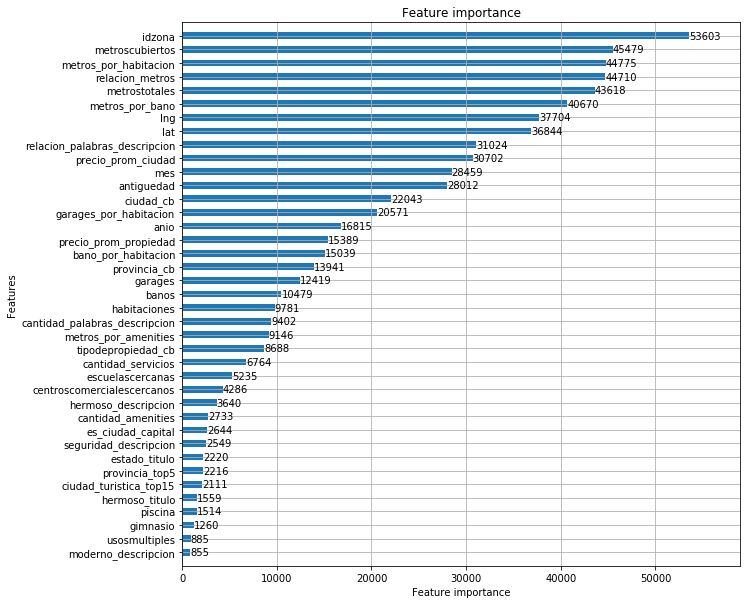

In [73]:
ax = lgb.plot_importance(LightGBM, height=0.5)
fig = ax.figure
fig.set_size_inches(10, 10)

In [74]:
LightGBM_pred_submit = LightGBM.predict(df_test, num_iteration=LightGBM.best_iteration)

In [75]:
resultado_submit = pd.DataFrame(index=df_test.index)
resultado_submit['id'] = id_col
resultado_submit['target'] = LightGBM_pred_submit
display(resultado_submit.head())
resultado_submit.to_csv('../data/submitLightGBM.csv',index=False)

,id,target
0,4941,7.724217e+06
1,51775,1.041522e+06
2,115253,2.287861e+06
3,299321,1.415052e+06
4,173570,5.776699e+05


#### Score en Kaggle (features => score):
 **1.** ***Usando CatBoost encoded*** y ['id',
 'antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'seguridad_titulo',
 'moderno_titulo',
 'hermoso_titulo',
 'estado_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***573846.94092*** con 'learning_rate': 0.03,
    'num_leaves': 256,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.7,
    'subsample' : 0.7,
    'min_split_gain' : 0.01,
    'min_data_in_leaf':10,
***LOCAL MAE: 568518.75474***

 **2.** ***Usando CatBoost encoded y k=30*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***532012.21935*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 522286.09996***

 **3.** ***Usando CatBoost encoded y k=40*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***530839.77082*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 521747.30395***